In [3]:
%load_ext lab_black
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
import matplotlib.pyplot as plt
from src.linear_coef_matching import LCM
from src.linear_coef_matching_mf import LCM_MF
from other_methods import prognostic
from Experiments.helpers import get_data
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [105]:
def lcm_aug_pgm(outcome, treatment, data, k_pgm=100, k_lcm=10):
    prog = prognostic.Prognostic(
        "Y", "T", df, method="linear", double=True, random_state=0
    )
    _, c_mg, t_mg = prog.get_matched_group(df, k=60, diameter_prune=None)
    mg = c_mg.join(t_mg, lsuffix="_c")

In [134]:
config = {
    "num_samples": 10000,
    "imp_c": 5,
    "unimp_c": 45,
    "imp_d": 0,
    "unimp_d": 0,
    "n_train": 0,
}
df, df_true, binary = get_data(data="dense_continuous", config=config)

In [135]:
df

,Y,T,X0,X1,X2,X3,X4,X5,X6,X7,...,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49
0,-54.877113,1,0.117986,-0.588603,-0.080815,0.706004,-0.989409,0.174068,1.897271,1.673363,...,-0.166387,-0.522139,-0.261031,-0.501634,0.071277,0.172076,0.350037,1.814387,0.585312,-0.455878
1,4.748231,1,1.021116,0.075959,-0.572963,0.130948,0.489879,1.282108,-0.512389,-1.067354,...,-0.480527,0.537530,0.990020,1.772078,-0.516267,1.069901,-0.069670,0.468741,-0.424686,1.780921
2,22.401810,1,0.644720,1.362902,-0.130496,0.818036,-1.238695,-0.246096,-0.750774,1.649813,...,0.463160,1.212925,-0.042949,0.695587,1.415333,-0.402656,-2.554383,-0.975254,-0.493009,-0.770375
3,67.870227,1,-0.563084,0.998847,-0.695449,-0.086742,0.636052,-1.454577,-0.618958,1.735204,...,2.054414,0.987860,0.114433,1.027987,2.672190,-1.147797,1.089676,0.078784,1.033433,0.342567
4,62.162460,0,0.491617,0.610201,-1.993158,-1.349580,0.255909,-0.198736,0.012734,1.039027,...,-0.677742,1.793783,-0.252771,0.242105,-0.753113,1.330124,-1.135905,1.493394,-1.783564,-1.580878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,53.466812,0,-0.717462,0.777645,-1.667187,-0.953756,-2.352593,0.684117,0.343021,-0.209613,...,-0.461664,-0.372208,-0.402753,0.759785,-0.931679,1.844171,1.470670,-0.969145,0.215193,-0.491434
9996,-79.089049,1,0.316422,-0.311371,-0.876870,0.962192,-2.190290,-2.564204,0.838887,0.023866,...,2.350500,2.289307,1.677206,-0.457197,0.070937,-0.043147,-2.292670,0.093264,-1.033352,-0.814275
9997,-55.198587,1,1.600406,-0.137779,-1.358062,0.676402,-0.756397,1.092373,0.100197,-1.503203,...,-0.248885,0.263625,-0.858737,0.306568,-1.606184,0.527032,-0.067898,-1.994413,-0.129672,-2.266686
9998,49.749256,1,-0.228375,-0.489098,0.419570,-1.184079,1.649973,-0.441730,-0.782700,-2.315135,...,-0.254100,-1.663346,-0.750450,0.484049,-0.633675,0.876907,0.742020,1.558556,0.906788,-0.471665


In [136]:
prog = prognostic.Prognostic(
    "Y", "T", df, method="ensemble", double=True, random_state=0
)
_, c_mg, t_mg = prog.get_matched_group(df, k=500, diameter_prune=None)
mg = c_mg.join(t_mg, lsuffix="_c")

0.9959353008276881
0.9947034163654216


In [137]:
def lcm_cates(row, df):
    idx = row.name
    matches = row.values
    df_ = df.loc[matches]
    match_tr = set(np.random.choice(matches, size=len(matches) // 2))
    if idx in match_tr:
        match_tr = set(matches).difference(match_tr)
    lcm = LCM("Y", "T", df_.loc[match_tr])
    lcm.fit()
    cates = lcm.CATE(
        df_estimation=df_.loc[set(matches).difference(match_tr)],
        k=5,
        diameter_prune=None,
    )
    cate_df = pd.DataFrame(cates)
    cate_df["idx"] = list(set(matches).difference(match_tr))
    return cate_df.loc[cate_df["idx"] == idx, "CATE_mean"].values[0]

In [ ]:
combo_cates = mg.apply(lcm_cates, df=df, axis=1)

In [ ]:
df_true["TE"]

In [115]:
lcm = LCM_MF("Y", "T", df, n_splits=2, n_repeats=1)
lcm.fit()
lcm.MG(k=5)
lcm.CATE(diameter_prune=None)
cate_df = lcm.cate_df

In [116]:
cate_df["avg.CATE_mean"]

0      14.443322
1     -19.299681
2      -0.156134
3      -8.020812
4       0.780661
         ...    
995    -2.042610
996   -24.700113
997     2.087572
998     6.069894
999     0.446618
Name: avg.CATE_mean, Length: 1000, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7acfba38b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7acfb43970>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7acfb7a580>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7acfb43c10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7acfb3bd00>],
 'means': []}

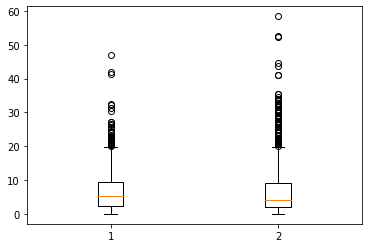

In [117]:
plt.boxplot(np.abs(combo_cates - df_true["TE"]), positions=[1])
plt.boxplot(np.abs(cate_df["avg.CATE_mean"] - df_true["TE"]), positions=[2])